In [1]:
import pandas as pd
import numpy as np

# Function to load and clean the data
def load_and_clean_data(file_path):
    # Load the data from an Excel file
    data = pd.read_excel(file_path)

    # Fill missing values in 'producing days' with zeros
    data['producing_days'].fillna(0, inplace=True)

    return data

# Function to calculate cumulative producing days
def calculate_cumulative_days(data):
    # Group by 'well_index' to calculate cumulative producing days for each well
    data['cumulative_producing_days'] = data.groupby('well_index')['producing_days'].cumsum()
    return data

# Function to calculate oil rate and water rate
def calculate_oil_water_rate(data):
    # Oil rate = Oil volume / Producing days
    # Water rate = Water volume / Producing days
    data['oil_rate'] = data['oil_volume'] / data['producing_days'].replace(0, np.nan)  # Avoid division by zero
    data['water_rate'] = data['water_volume'] / data['producing_days'].replace(0, np.nan)  # Avoid division by zero
    return data

# Function to calculate WOR (Water Oil Ratio)
def calculate_WOR(data):
    # WOR = Water rate / Oil rate
    data['WOR'] = data['water_rate'] / data['oil_rate'].replace(0, np.nan)  # Avoid division by zero
    return data

# Function to calculate WOR derivative using central differencing
def calculate_WOR_derivative(data):
    # Group by 'well_index' to calculate the derivative for each well separately
    data['WOR_derivative'] = np.gradient(data.WOR, data.cumulative_producing_days)
    return data

# Assuming this function saves or processes the final data and makes plots.
def analyze_water_production(file_path):
    # Step 1: Load and clean data
    data = load_and_clean_data(file_path)
    
    # Step 2: Calculate cumulative producing days
    data = calculate_cumulative_days(data)
    
    # Step 3: Calculate oil rate and water rate
    data = calculate_oil_water_rate(data)
    
    # Step 4: Calculate Water-Oil Ratio (WOR)
    data = calculate_WOR(data)
    
    # Step 5: Calculate WOR derivative (for diagnosis)
    data = calculate_WOR_derivative(data)

    # Step 6: Return processed data for further use (e.g., plotting or exporting)
    return data

# Example call to the function (commented out since we cannot read files in this environment)
file_path = 'Downloads/TST-Code for Chan.xlsx'
processed_data = analyze_water_production(file_path)



C:\Users\joseph.abua\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1084: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\joseph.abua\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1085: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\joseph.abua\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1086: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))


C:\Users\joseph.abua\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1084: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\joseph.abua\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1085: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\joseph.abua\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1086: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))


Processed data saved to Downloads/processed_tst code for chan.xlsx


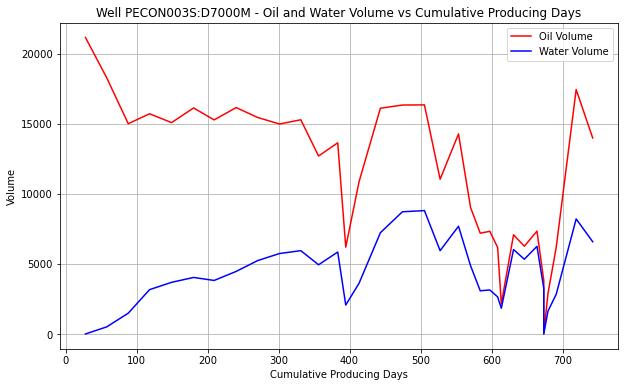

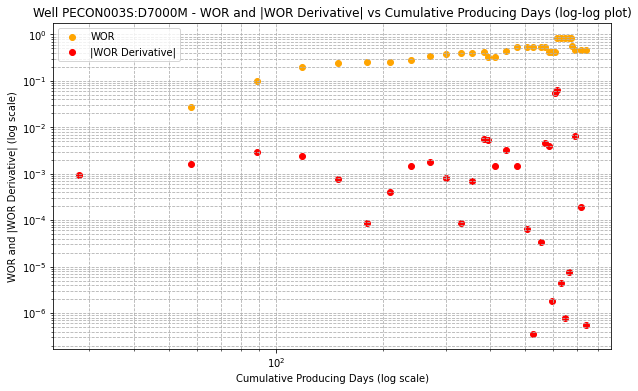

Diagnosis results: {'PECON003S:D7000M': 'Channeling Problem'}


In [2]:
import matplotlib.pyplot as plt
# Function to save processed data back to an Excel file
def save_to_excel(data, output_file):
    # Save the modified dataframe with new columns to a new Excel file
    data.to_excel(output_file, index=False)
    print(f"Processed data saved to {output_file}")

    # Function to plot oil and water volumes vs cumulative producing days
def plot_oil_water_volumes(data):
    wells = data['well_index'].unique()
    for well in wells:
        well_data = data[data['well_index'] == well]
        
        plt.figure(figsize=(10, 6))
        plt.plot(well_data['cumulative_producing_days'], well_data['oil_volume'], label='Oil Volume', color='red')
        plt.plot(well_data['cumulative_producing_days'], well_data['water_volume'], label='Water Volume', color='blue')
        plt.xlabel('Cumulative Producing Days')
        plt.ylabel('Volume')
        plt.title(f'Well {well} - Oil and Water Volume vs Cumulative Producing Days')
        plt.legend()
        plt.grid(True)
        plt.show()

# Modified plotting function to handle WOR derivative properly
def plot_log_log_WOR(data):
    wells = data['well_index'].unique()
    for well in wells:
        well_data = data[data['well_index'] == well]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(well_data['cumulative_producing_days'], well_data['WOR'], label='WOR', color='orange')
        
        # Plot the absolute values of WOR derivative to avoid log issues with negative values
        plt.scatter(well_data['cumulative_producing_days'], np.abs(well_data['WOR_derivative']), label='|WOR Derivative|', color='red')
        plt.xscale('log')
        plt.yscale('log')

        plt.xlabel('Cumulative Producing Days (log scale)')
        plt.ylabel('WOR and |WOR Derivative| (log scale)')
        plt.title(f'Well {well} - WOR and |WOR Derivative| vs Cumulative Producing Days (log-log plot)')
        plt.legend()
        plt.grid(True, which="both", ls="--")
        plt.show()
def diagnose_well(data):
    diagnosis = {}
    wells = data['well_index'].unique()
    
    for well in wells:
        well_data = data[data['well_index'] == well]
        derivative = well_data['WOR_derivative']
        
        # Calculate the average slope of the WOR derivative
        avg_slope = np.mean(derivative)
        
        # Diagnose based on the sign of the slope
        if avg_slope > 0:
            diagnosis[well] = 'Channeling Problem'
        else:
            diagnosis[well] = 'Coning Problem'
    
    return diagnosis
# Full pipeline function that now saves results to a file
def analyze_and_save_water_production(file_path, output_file):
    # Load, process, and analyze data
    data = analyze_water_production(file_path)
    
    # Save the calculated results to Excel
    save_to_excel(data, output_file)
    
    # Generate the plots for visual analysis
    plot_oil_water_volumes(data)
    plot_log_log_WOR(data)
    
    # Diagnose well issues (channeling or coning)
    diagnosis_result = diagnose_well(data)
    print("Diagnosis results:", diagnosis_result)

# Example call to the modified function (commented out since file I/O isn't possible here)
analyze_and_save_water_production('Downloads/TST-Code for Chan.xlsx', 'Downloads/processed_tst code for chan.xlsx')

